In [2]:
# First, import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Generate sine wave data
def generate_data(seq_length, num_samples):
    X = []
    y = []
    
    for i in range(num_samples):
        x = np.linspace(i, i + seq_length, seq_length)
        X.append(np.sin(x))  # Input sequence is a sine wave
        y.append(np.sin(i + seq_length))  # Predict the next value in the sequence
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
seq_length = 50  # Length of the sine wave sequence
num_samples = 1000  # Number of samples to generate

X, y = generate_data(seq_length, num_samples)

# Reshape to match PyTorch's expected input
X = X.reshape((num_samples, seq_length, 1))  # (batch_size, seq_length, input_size)
y = y.reshape((num_samples, 1))  # (batch_size, output_size)

# Split data into training and testing sets
train_size = int(0.8 * num_samples)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [16]:
# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)

Training Data Shape: torch.Size([800, 50, 1])
Training Labels Shape: torch.Size([800, 1])


In [7]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out

# Model parameters
input_size = 1  # Sine wave input size
hidden_size = 50  # Number of hidden units
output_size = 1  # Output size (predicting one value)

# Instantiate the model
model = RNNModel(input_size, hidden_size, output_size)

In [8]:
# Define the loss function and optimizer
criterion = nn.L1Loss()  # Mean Absolute Error (same as 'mae' in Keras)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training parameters
num_epochs = 5
batch_size = 32

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for i in range(0, len(X_train), batch_size):
        # Get a batch of data
        batch_X = X_train[i:i + batch_size]
        batch_y = y_train[i:i + batch_size]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(X_train):.4f}')


Epoch [1/5], Loss: 0.0084
Epoch [2/5], Loss: 0.0010
Epoch [3/5], Loss: 0.0003
Epoch [4/5], Loss: 0.0003
Epoch [5/5], Loss: 0.0004


In [10]:
# Test the model on unseen data
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.0121


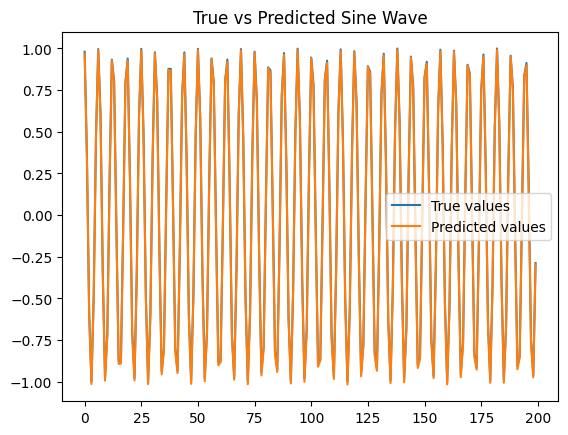

In [13]:
# Plot the predicted values vs the true values
plt.plot(y_test, label='True values')
plt.plot(predictions, label='Predicted values')
plt.legend()
plt.title('True vs Predicted Sine Wave')
plt.show()
